<a href="https://colab.research.google.com/github/czs-school-23/bayesian-ml/blob/main/stellar_spectra_example_emily.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial setup
Firstly, let's import everything we'll need.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
import os
from pathlib import Path
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from scipy.stats import iqr as interquartile_range
from scipy.stats import gaussian_kde
from scipy.signal import medfilt

Next, we need to download the repository containing our data.

In [2]:
!git clone "https://github.com/czs-school-23/bayesian-ml"
os.chdir("bayesian-ml")

Cloning into 'bayesian-ml'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 41 (delta 15), reused 17 (delta 3), pack-reused 0
Receiving objects: 100% (41/41), 7.03 MiB | 21.28 MiB/s, done.
Resolving deltas: 100% (15/15), done.


Now, let's load the data we'll be using.

In [3]:
list(Path(".").glob("data/*/*"))

[PosixPath('data/stellar_spectra/properties.csv'),
 PosixPath('data/stellar_spectra/spectra.npy'),
 PosixPath('data/stellar_spectra/wavelengths.npy'),
 PosixPath('data/curve/curve.py'),
 PosixPath('data/curve/data.npy'),
 PosixPath('data/curve/curve.png')]

In [4]:
spectra = np.load("data/stellar_spectra/spectra.npy")
properties = pd.read_csv("data/stellar_spectra/properties.csv")

# In log angstroms by default. Converted to nm because personal preference =)
wavelengths = np.exp(np.load("data/stellar_spectra/wavelengths.npy")) / 10

# Inspecting the data
Let's take a look at what we're working with!

These are the parameters of the first five spectra:

In [5]:
properties.head()

,t_eff,log_g,feh,afe,v_mic,phase,age,v_macro,h_abundance,he_abundance,filename
0,4932.1777,4.274360,0.5,0.419682,3.008605,-1,7.10,0.0,0.914398,0.079920,b'X0000'
1,4670.5576,0.960434,0.5,-0.099054,2.158830,0,7.15,0.0,0.919236,0.078108,b'X0001'
2,6180.6104,4.077509,0.5,0.323485,3.652777,-1,7.20,0.0,0.915778,0.079401,b'X0002'
3,6798.6284,4.111562,0.5,0.336346,2.158780,0,7.20,0.0,0.915610,0.079464,b'X0003'
4,4129.8010,0.905774,0.5,0.176030,1.875668,0,7.20,0.0,0.917379,0.078801,b'X0004'


## Histograms

These are overall histograms of the parameters we'd like to fit: t_eff, log_g, and feh.

Text(0, 0.5, 'Count')

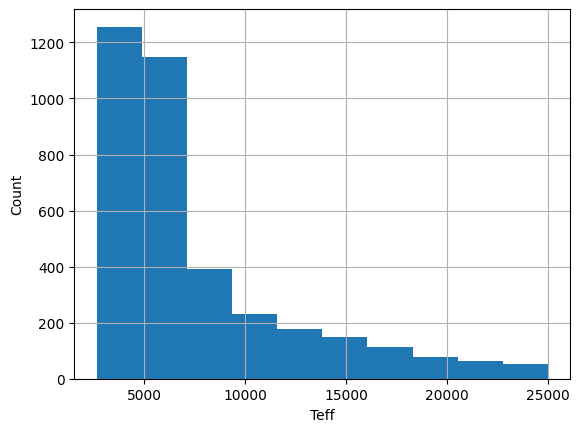

In [18]:
properties['t_eff'].hist()
plt.xlabel("Teff")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

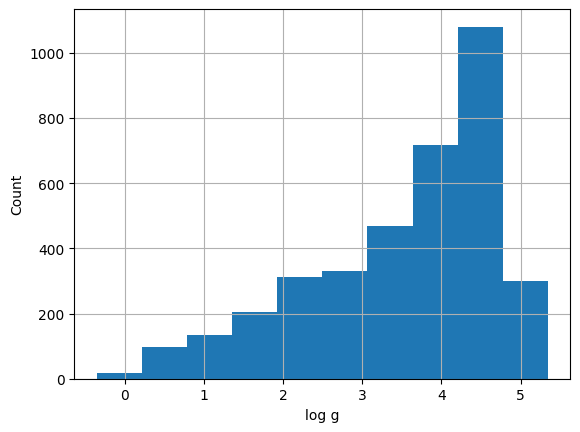

In [19]:
properties['log_g'].hist()
plt.xlabel("log g")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

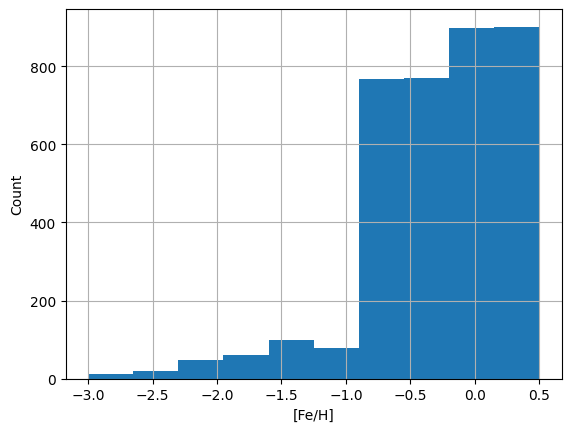

In [20]:
properties['feh'].hist()
plt.xlabel("[Fe/H]")
plt.ylabel("Count")

Text(0, 0.5, 'log g')

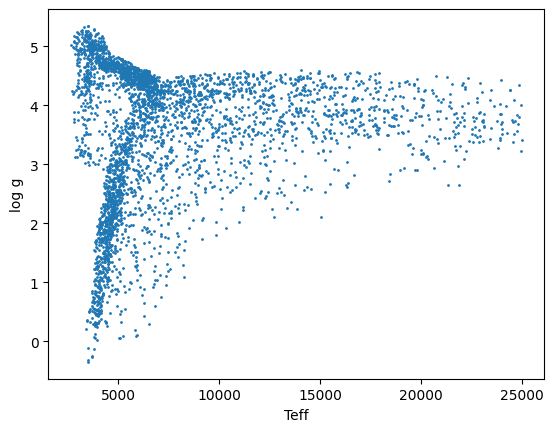

In [21]:
plt.scatter(properties["t_eff"], properties["log_g"], s=1)
plt.xlabel("Teff")
plt.ylabel("log g")

## Spectra
Here are a few of the spectra, plotted to have the same area:

Text(0.5, 0, 'Wavelength (nm)')

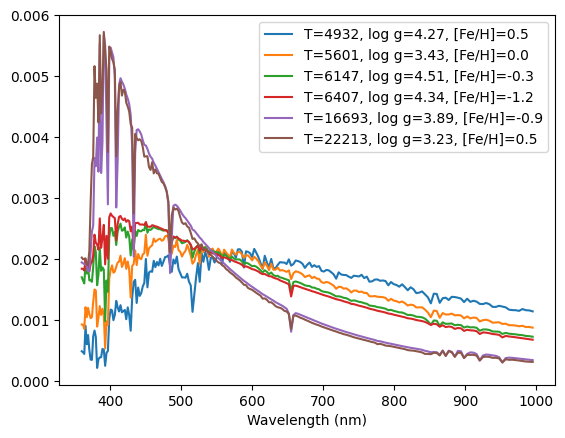

In [30]:
for i in [0, 1500, 500, 1000, 3000, 2000]:
    label = f"T={properties.loc[i, 't_eff']:.0f}, log g={properties.loc[i, 'log_g']:.2f}, [Fe/H]={properties.loc[i, 'feh']:.1f}"
    plt.plot(wavelengths, spectra[i] / np.trapz(spectra[i], wavelengths), label=label)

plt.legend()
plt.xlabel("Wavelength (nm)")

# Preprocessing
Before going any further, we should standardise all the spectral data a bit.

We'll give everything a unit inter-quartile range (a bit more robust than unit variance). In addition, we'll use median filtering to remove the Planck function from the spectra, as we're mostly just interested in the lines.

(Aside: it would be better to still feed peak of the distribution to the network some way to improve Teff accuracy.)

In [6]:
# Scale each spectrum based on its interquartile range & apply median filtering
x = spectra.copy()
x = x / interquartile_range(x, axis=1).reshape(-1, 1)
x_scaled = np.asarray([s - medfilt(s, 21) for s in x])

# We'll also scale our output to have unit iqr and zero median
y = properties[["t_eff", "log_g", "feh"]].to_numpy().copy()
output_scaler = RobustScaler()
y_scaled = output_scaler.fit_transform(y)

# Split into 80% training, 20% test
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_scaled, random_state=42, train_size=0.8)

Text(0.5, 0, 'Wavelength (nm)')

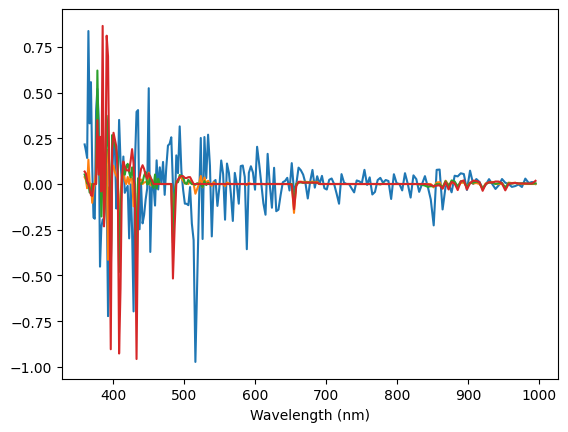

In [7]:
for s in x_scaled[::1000]:
    plt.plot(wavelengths, s)

plt.xlabel("Wavelength (nm)")

In [32]:
x_train.shape, x_test.shape

((2928, 210), (732, 210))

We have about 3000 examples to train on and 730 to test on.

# A basic network
Let's try making a basic network to infer properties with these spectra. There's no point Bayesianifying our problem if we can't get something simple working! We'll use a small, 1D convolutional neural net (CNN) for this problem.

The small size of these networks makes them easy to train and play around with, while the CNN part is great at doing pattern recognition on our spectra & finding spectral features.

In [ ]:
model = keras.Sequential([
    keras.layers.Reshape((210, 1)),
    keras.layers.Convolution1D(40, 7, 2, activation="relu"),
    keras.layers.Flatten(),
    keras.layers.Dense(200, activation="relu"),
    keras.layers.Dense(60, activation="relu"),
    keras.layers.Dense(3)
])

In [ ]:
model.compile(
    loss="MeanSquaredError",
    metrics=['MeanSquaredError'],
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4)
)

model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=10)],
    epochs=300,
    verbose=1
)

Epoch 1/300
92/92 [==============================] - 2s 7ms/step - loss: 0.5592 - mean_squared_error: 0.5592 - val_loss: 0.3874 - val_mean_squared_error: 0.3874
Epoch 2/300
92/92 [==============================] - 0s 5ms/step - loss: 0.3176 - mean_squared_error: 0.3176 - val_loss: 0.2578 - val_mean_squared_error: 0.2578
Epoch 3/300
92/92 [==============================] - 0s 5ms/step - loss: 0.2280 - mean_squared_error: 0.2280 - val_loss: 0.1912 - val_mean_squared_error: 0.1912
Epoch 4/300
92/92 [==============================] - 0s 5ms/step - loss: 0.1766 - mean_squared_error: 0.1766 - val_loss: 0.1514 - val_mean_squared_error: 0.1514
Epoch 5/300
92/92 [==============================] - 0s 5ms/step - loss: 0.1528 - mean_squared_error: 0.1528 - val_loss: 0.1316 - val_mean_squared_error: 0.1316
Epoch 6/300
92/92 [==============================] - 0s 5ms/step - loss: 0.1373 - mean_squared_error: 0.1373 - val_loss: 0.1221 - val_mean_squared_error: 0.1221
Epoch 7/300
92/92 [===============

In [ ]:
y_predicted = output_scaler.inverse_transform(model(x_test))
y_targets = output_scaler.inverse_transform(y_test)

[Text(0.5, 1.0, '[Fe/H]')]

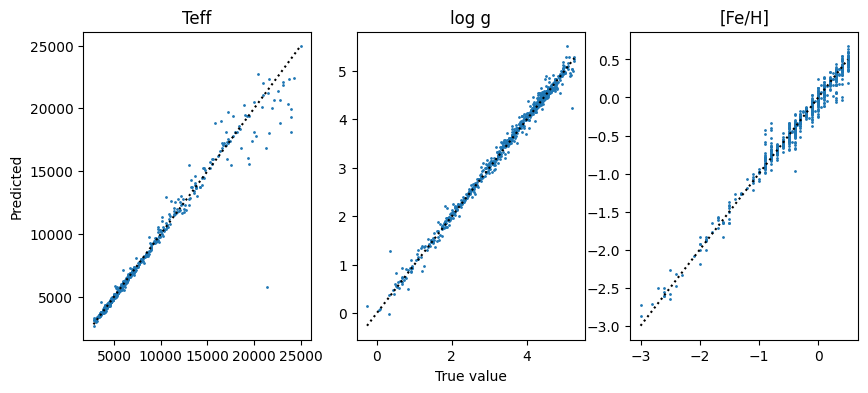

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(10, 4))

for i in range(3):
    ax[i].scatter(y_targets[:, i], y_predicted[:, i], s=1)
    min, max = y_targets[:, i].min(), y_targets[:, i].max()
    ax[i].plot([min, max], [min, max], 'k:')

ax[0].set(title="Teff", ylabel="Predicted")
ax[1].set(title="log g", xlabel="True value")
ax[2].set(title="[Fe/H]")

It works pretty well! But wouldn't it be more fun if it also gave us uncertainty estimates?

# Bayesianifying it with Flipout

## Our loss functions
Firstly, we should define the loss functions we want to minimise with our network. We'll be minimising the [evidence lower bound (ELBO) loss](https://en.wikipedia.org/wiki/Evidence_lower_bound), which is a sum of two things:

1. The negative log likelihood of our network's predicted distributions vs. the true values of our training data

2. The KL divergence of every parameter's approximate distribution vs. the actual distribution of each parameter during training.

1) is something you might have seen in Bayesian modelling before. 2) exists to make sure our variational distributions are good approximations to the true posterior distribution of each weight in the network.

1) is easy to define:

In [ ]:
@tf.function
def negative_loglikelihood(y, estimated_distribution):
    return -estimated_distribution.log_prob(y)

2) is a bit weird in Tensorflow Probability. It's added onto the loss automatically by each layer, but we have to weight it by the amount of training data we have *and* (maybe, I'm honestly not sure) also by the total number of parameters our model has (about 4300.)

In [ ]:
@tf.function
def kl_divergence(q, p, _):
    """We have to weight the KL divergence of every layer by the number of
    training samples and the number of trainable parameters (roughly, I
    think...)
    """
    return tfp.distributions.kl_divergence(q, p) / x_train.shape[0] / 4300

## Our model

In [8]:
def get_model(input_shape=210):
    # Process the input
    input = keras.layers.Input(shape=(input_shape,))
    x = keras.layers.Reshape((input_shape, 1))(input)

    # Standard config we pass to every layer (our loss function for each parameter, weighted.)
    flipout_config = dict(
        kernel_divergence_fn=kl_divergence,
        bias_divergence_fn=kl_divergence
    )

    # Main parts of the network
    x = tfp.layers.Convolution1DFlipout(40, 11, 2, activation="relu", **flipout_config)(x)
    x = keras.layers.Flatten()(x)
    x = tfp.layers.DenseFlipout(200, activation="relu", **flipout_config)(x)
    x = tfp.layers.DenseFlipout(100, activation="relu", **flipout_config)(x)

    # Output - we learn 3 means and 3 standard deviations, which each need different activations. Our means can take
    # any value, so we don't bias them with an activation at all. On the other hand, standard deviations should always
    # be positive and non-zero, so we use a softplus activation & also add a small constant minimum (1e-4) later on to
    # stop the output distributions from ever being too unrealistically small. (This is important to make the network
    # trainable while only using floating point precision.)
    # SO, these are our means and standard deviations on our parameters:
    means = tfp.layers.DenseFlipout(3, activation=None, **flipout_config)(x)
    standards = tfp.layers.DenseFlipout(3, activation="softplus", **flipout_config)(x)

    # Which we then concatenate into a single length 6 tensor for... reasons. Basically, our final output has to be a
    # DistributionLambda layer, and it can only take a single tensor.
    parameters = keras.layers.Concatenate()([means, standards])

    # Our distribution output! This layer takes our means (the first 3 values in the tensor) and our standard deviations
    # (the last 3 values) and plugs them into a normal distribution. Yeah, you read that right - our network actually
    # outputs a Distribution object that we can sample, and not just a single point estimate.
    output = tfp.layers.DistributionLambda(
        lambda t: tfd.Normal(loc=t[..., :3], scale=1e-4 + t[..., 3:])
    )(parameters)

    return keras.Model(inputs=input, outputs=output)

## Train the model

In [9]:
model = get_model()

model.compile(
    loss=negative_loglikelihood,  # the KL divergence of every distribution is added on automatically
    #metrics=[mean_squared_error],
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    #steps_per_execution=batch_size  # ?
)

model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=10)],
    epochs=500,
    verbose=1,
    # sample_weight=training_weights
    #batch_size=batch_size
)

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


Epoch 1/500
92/92 [==============================] - 17s 22ms/step - loss: 1.3487 - val_loss: 1.1379
Epoch 2/500
92/92 [==============================] - 2s 18ms/step - loss: 1.0841 - val_loss: 1.0044
Epoch 3/500
92/92 [==============================] - 1s 12ms/step - loss: 0.9629 - val_loss: 0.9011
Epoch 4/500
92/92 [==============================] - 1s 11ms/step - loss: 0.8757 - val_loss: 0.8322
Epoch 5/500
92/92 [==============================] - 1s 11ms/step - loss: 0.7947 - val_loss: 0.7325
Epoch 6/500
92/92 [==============================] - 1s 11ms/step - loss: 0.7106 - val_loss: 0.6573
Epoch 7/500
92/92 [==============================] - 1s 11ms/step - loss: 0.6563 - val_loss: 0.5476
Epoch 8/500
92/92 [==============================] - 1s 11ms/step - loss: 0.5760 - val_loss: 0.5275
Epoch 9/500
92/92 [==============================] - 1s 11ms/step - loss: 0.5154 - val_loss: 0.4667
Epoch 10/500
92/92 [==============================] - 1s 11ms/step - loss: 0.4688 - val_loss: 0.412

## Results!

We first need to sample the model:

In [25]:
# Sample the model multiple times to get epistemic uncertainty
n_samples = 100
samples = np.zeros((100, y_test.shape[0], y_test.shape[1]))
for i in range(n_samples):
    print(f"\rSampling round {i+1}", end="")
    samples[i] = model(x_test).sample()  # We predict a Distribution and then sample each one once
print("")

# Get means and standard deviations on our samples.
means = np.mean(samples, axis=0)
stds = np.std(samples, axis=0)

# We also need to convert these values from the rescaled network parameters into human-readable results.
y_predicted = output_scaler.inverse_transform(means)
y_error = output_scaler.inverse_transform(means + stds) - y_predicted
y_targets = output_scaler.inverse_transform(y_test)

print(f"Mean squared error: {np.mean((means - y_test)**2):.5f}")

Sampling round 100
Mean squared error: 0.02705


Let's plot it!

[Text(0.5, 1.0, '[Fe/H]')]

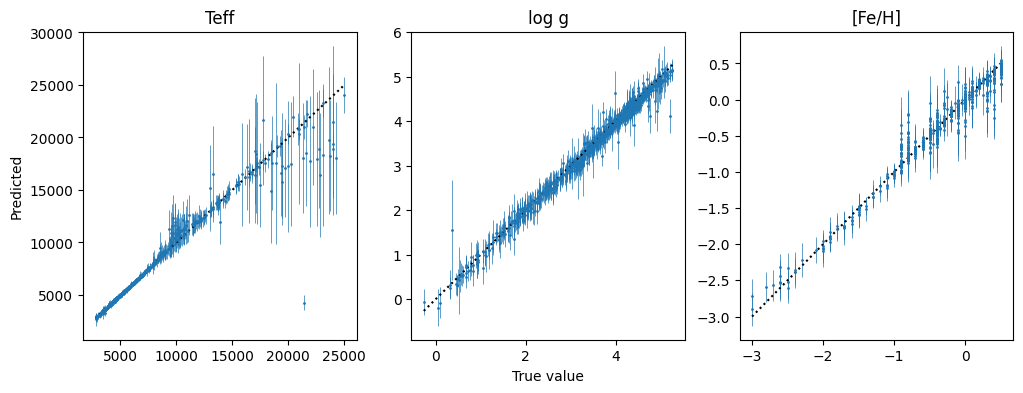

In [21]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 4))

for i in range(3):
    ax[i].errorbar(y_targets[:, i], y_predicted[:, i], fmt='o', ms=1, yerr=y_error[:, i], elinewidth=0.5)
    min, max = y_targets[:, i].min(), y_targets[:, i].max()
    ax[i].plot([min, max], [min, max], 'k:')

ax[0].set(title="Teff", ylabel="Predicted")
ax[1].set(title="log g", xlabel="True value")
ax[2].set(title="[Fe/H]")

## Unseen data
What happens when we try running the network on completely unseen data? (Out of distribution or OOD)

This was just a quick experiment where we made a "blended" spectrum by adding multiple together.

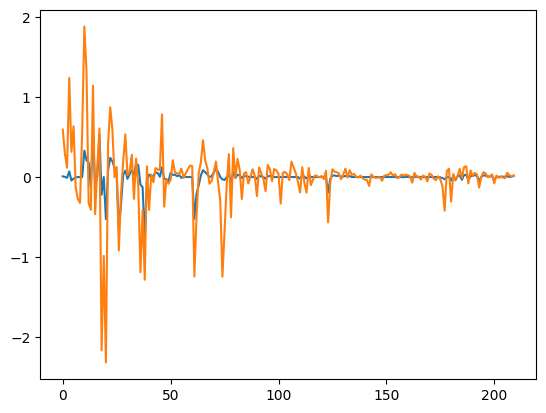

In [28]:
test_spectrum_of_doom = x_test[0] + x_test[1] + x_test[2] + x_test[3] + x_test[4]

plt.plot(x_test[0])
plt.plot(test_spectrum_of_doom)

In [29]:
# Sample the model multiple times to get epistemic uncertainty
n_samples = 100
samples = np.zeros((100, 1, y_test.shape[1]))
for i in range(n_samples):
    print(f"\rSampling round {i+1}", end="")
    samples[i] = model(test_spectrum_of_doom.reshape(1, -1)).sample()  # We predict a Distribution and then sample each one once

print("")

means = np.mean(samples, axis=0)
stds = np.std(samples, axis=0)

y_predicted = output_scaler.inverse_transform(means)
y_error = output_scaler.inverse_transform(means + stds) - y_predicted

print(f"Predicted values: {y_predicted}")
print(f"Uncertainties: {y_error}")
print(f"Percentage uncertainties: {y_error / y_predicted * 100}")

Sampling round 100
Predicted values: [[6.39309661e+03 4.43789954e+00 1.08102654e+00]]
Uncertainties: [[2.49250383e+02 1.24996344e-01 9.28249755e-02]]
Percentage uncertainties: [[3.89874263 2.81656542 8.58674343]]


The network has **3% to 8%** uncertainty on parameters here when it's running on a completely OOD spectrum. I.e.: this spectrum is unphysical and doesn't exist, but it claims it can get values from it!

This is *bad* and is a typical flaw of variational inference-based approaches: they're quite bad at correctly predicting model uncertainties when ran on OOD data.

# Noisy data
What happens when we train & test a Bayesain network on noisy data? Can it correctly predict uncertainties in this case?

## Making some noisy training data
This is a quick hack to add some Gaussian noise to our spectra.

In [33]:
rng = np.random.default_rng(10)

x_train_noisy = []
for uncertainty in np.linspace(0, np.std(x_train), num=10):
    x_train_noisy.append(x_train + rng.normal(scale=uncertainty, size=x_train.shape))
x_train_noisy = np.asarray(x_train_noisy).reshape(2928*10, 210)

y_train_noisy = np.tile(y_train, (10, 1))

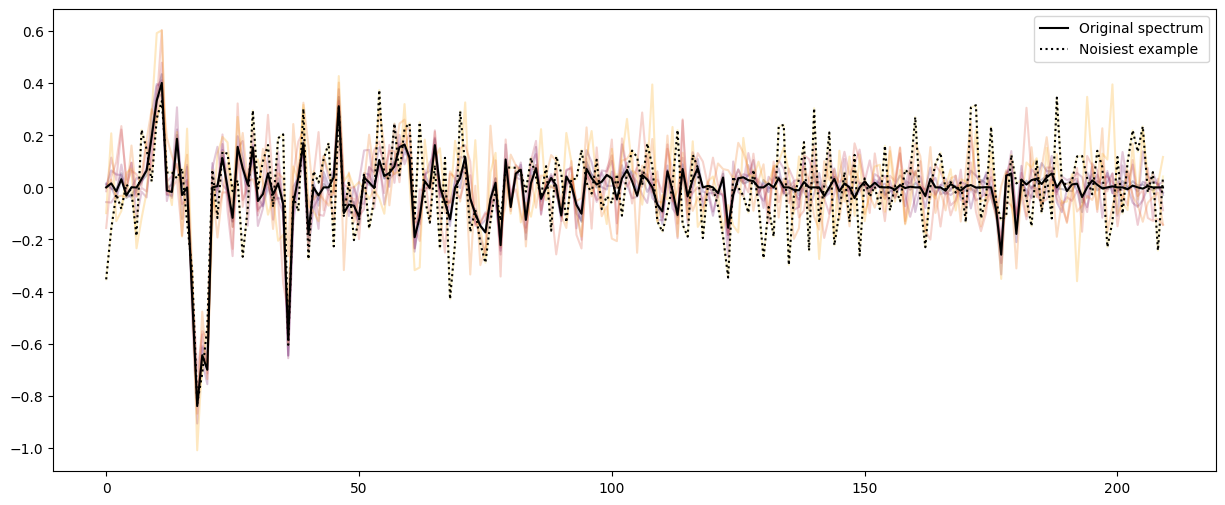

In [34]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(x_train_noisy[0], 'k-', zorder=1000, label="Original spectrum")
cmap = plt.get_cmap("inferno")
for i in range(9):
    ax.plot(x_train_noisy[(i+1)*2928], alpha=0.25, color=cmap((i + 1)/10))

ax.plot(x_train_noisy[9*2928], 'k:', zorder=1000, label="Noisiest example")
ax.legend()

Our "noise" simulates having lots of noisy pixels, which look a bit like having lots of additional lines.

## Train the model

In [11]:
model = get_model()

model.compile(
    loss=negative_loglikelihood,  # the KL divergence of every distribution is added on automatically
    #metrics=[mean_squared_error],
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    #steps_per_execution=batch_size  # ?
)

model.fit(
    x_train_noisy,
    y_train_noisy,
    validation_data=(x_test, y_test),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=10)],
    epochs=500,
    verbose=1,
    # sample_weight=training_weights
    #batch_size=batch_size
)

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


Epoch 1/500
915/915 [==============================] - 26s 9ms/step - loss: 0.9949 - val_loss: 0.6579
Epoch 2/500
915/915 [==============================] - 9s 10ms/step - loss: 0.6385 - val_loss: 0.4042
Epoch 3/500
915/915 [==============================] - 9s 10ms/step - loss: 0.4975 - val_loss: 0.3186
Epoch 4/500
915/915 [==============================] - 9s 9ms/step - loss: 0.3961 - val_loss: 0.1966
Epoch 5/500
915/915 [==============================] - 10s 10ms/step - loss: 0.3122 - val_loss: 0.0727
Epoch 6/500
915/915 [==============================] - 12s 13ms/step - loss: 0.2410 - val_loss: 0.0063
Epoch 7/500
915/915 [==============================] - 9s 10ms/step - loss: 0.1835 - val_loss: -0.0745
Epoch 8/500
915/915 [==============================] - 10s 10ms/step - loss: 0.1262 - val_loss: -0.0928
Epoch 9/500
915/915 [==============================] - 9s 10ms/step - loss: 0.0807 - val_loss: -0.1791
Epoch 10/500
915/915 [==============================] - 10s 11ms/step - loss:

## Results!
Get some predictions for noisy data:

In [12]:
# Sample the model multiple times to get epistemic uncertainty
n_samples = 100
samples = np.zeros((100, y_test.shape[0], y_test.shape[1]))
for i in range(n_samples):
    print(f"\rSampling round {i+1}", end="")
    samples[i] = model(x_test).sample()  # We predict a Distribution and then sample each one once

print("")

means = np.mean(samples, axis=0)
stds = np.std(samples, axis=0)

y_predicted = output_scaler.inverse_transform(means)
y_error = output_scaler.inverse_transform(means + stds) - y_predicted
y_targets = output_scaler.inverse_transform(y_test)

print(f"Mean squared error: {np.mean((means - y_test)**2):.5f}")

Sampling round 100
Mean squared error: 0.03149


... and some predictions for noisy data

In [13]:
# Sample the model multiple times to get epistemic uncertainty
rng = np.random.default_rng(10)

# This is how much our "measurement" is off on average from the true value, i.e. the amount of random noise we measure.
noise_scale = 1.0 * np.std(x_train)

# This is how big our "measured error" is on the same scale. If we have a "measurement" with perfectly understood error,
# then this is the same as the real random noise scale. The network's input is resampled from this.
error_scale = 1.0 * np.std(x_train)

# Let's add some random noise to the perfect measurements
perturbation = rng.normal(scale=noise_scale*np.std(x_train), size=x_test.shape)
x_test_noisy = x_test + perturbation

# ... and take 100 samples with the network, resampling our spectrum each time based on our expected error on it
n_samples = 100
samples_noisy = np.zeros((100, y_test.shape[0], y_test.shape[1]))
for i in range(n_samples):
    print(f"\rSampling round {i+1}", end="")
    perturbation = rng.normal(scale=error_scale, size=x_test.shape)
    samples_noisy[i] = model(x_test_noisy + perturbation).sample()

print("")

means_noisy = np.mean(samples_noisy, axis=0)
stds_noisy = np.std(samples_noisy, axis=0)

y_predicted_noisy = output_scaler.inverse_transform(means_noisy)
y_error_noisy = output_scaler.inverse_transform(means_noisy + stds_noisy) - y_predicted_noisy

print(f"Mean squared error: {np.mean((means_noisy - y_test)**2):.5f}")

Sampling round 100
Mean squared error: 0.11621


... and compare them on a plot!

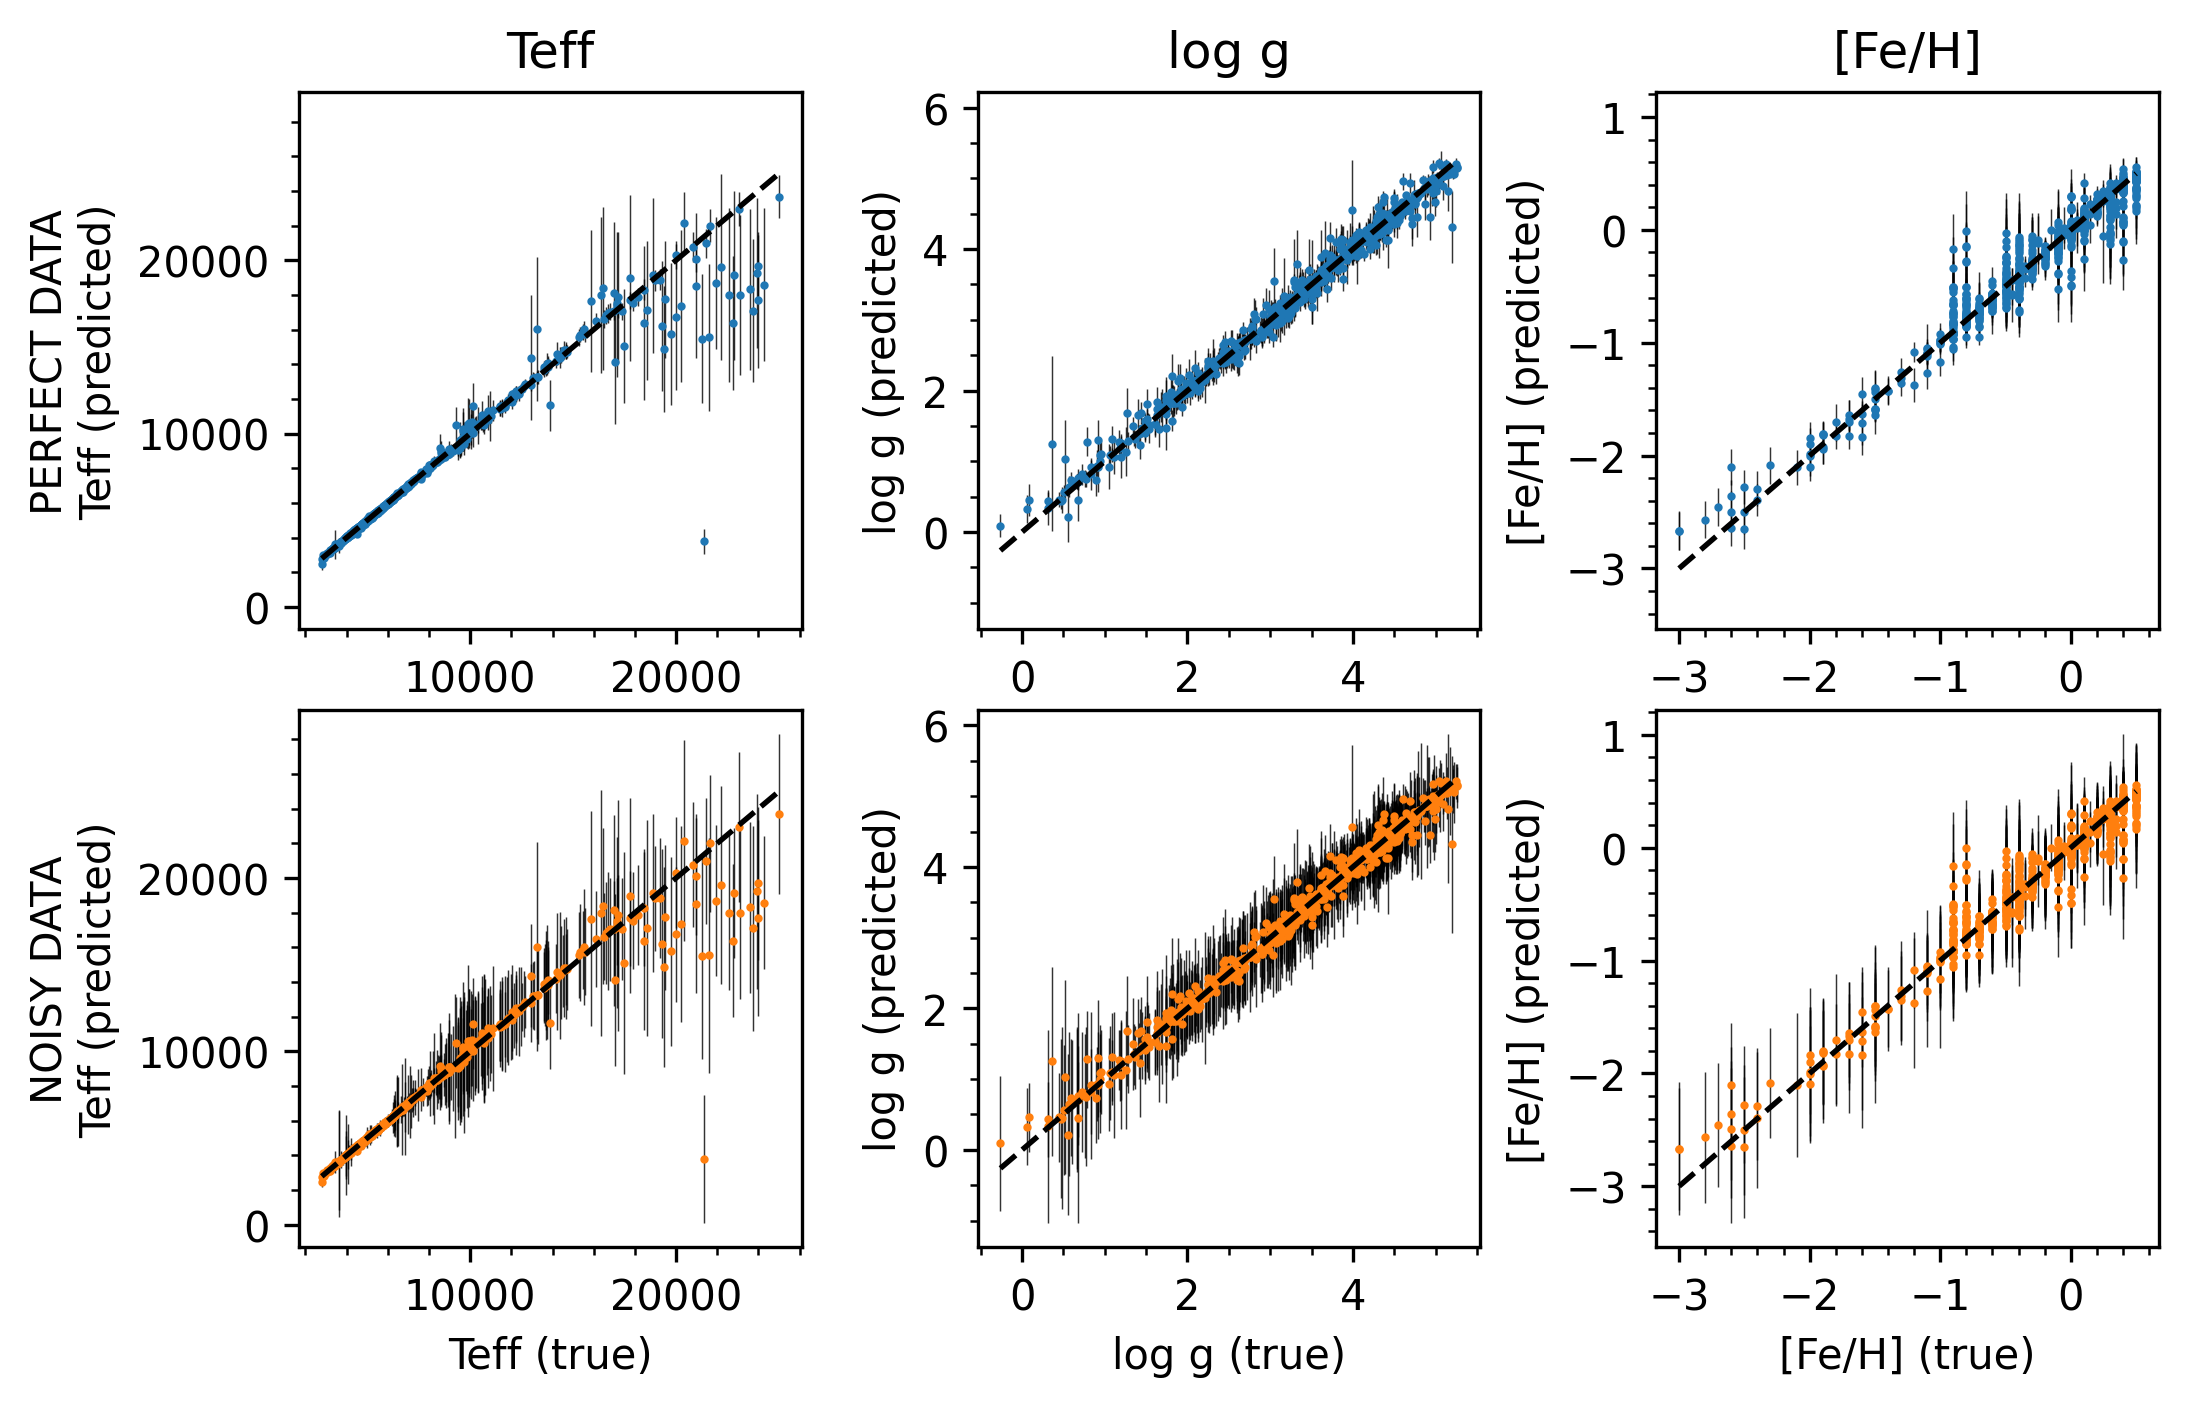

In [16]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(8, 5), dpi=300)

cmap = plt.get_cmap("tab10")
ecolor = (0, 0, 0, 0.8)

for i in range(3):
    ax[0, i].errorbar(y_targets[:, i], y_predicted[:, i], fmt='.', ms=2, yerr=y_error[:, i], elinewidth=0.35, color=cmap(0), ecolor=ecolor)
    ax[1, i].errorbar(y_targets[:, i], y_predicted[:, i], fmt='.', ms=2, yerr=y_error_noisy[:, i], elinewidth=0.35, color=cmap(1), ecolor=ecolor)
    min, max = y_targets[:, i].min(), y_targets[:, i].max()
    ax[0, i].plot([min, max], [min, max], '--', zorder=1000, lw=1.3, alpha=1., color="k")
    ax[1, i].plot([min, max], [min, max], '--', zorder=1000, lw=1.3, alpha=1., color="k")

ax[0, 0].set(ylabel="PERFECT DATA\nTeff (predicted)", title="Teff")
ax[0, 1].set(ylabel="log g (predicted)", title="log g")
ax[0, 2].set(ylabel="[Fe/H] (predicted)", title="[Fe/H]")
ax[1, 0].set(ylabel="NOISY DATA\nTeff (predicted)", xlabel="Teff (true)")
ax[1, 1].set(ylabel="log g (predicted)", xlabel="log g (true)")
ax[1, 2].set(ylabel="[Fe/H] (predicted)", xlabel="[Fe/H] (true)")

ax[0, 0].set(xlim=ax[1, 0].get_xlim(), ylim=ax[1, 0].get_ylim(),)
ax[0, 1].set(xlim=ax[1, 1].get_xlim(), ylim=ax[1, 1].get_ylim(),)
ax[0, 2].set(xlim=ax[1, 2].get_xlim(), ylim=ax[1, 2].get_ylim(),)

for an_ax in ax.flatten():
    an_ax.minorticks_on()

fig.subplots_adjust(wspace=0.35, hspace=0.15)

The network seemed to learn what uncertainty is! (At least in our basic case.) In some cases (like low temperatures below 6000 K) it still has high accuracy and low uncertainty; in other areas, error bars are generally a lot higher.